# Amazon Dataset 
Description of the dataset ....

In [1]:
import os
import time
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import distanceclosure as dc
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx, from_networkx
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import remove_self_loops
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import torch_geometric.transforms as T
from torch_geometric.datasets import Amazon
import torch_geometric.transforms.to_device
from src import add_weights_to_edges, mb_sparsify, generate_train_and_test_mask, GCN, train, test, eval_model, get_edge_idx_from_adj_matrix, get_num_edges_from_adj_matrix, random_sparsify, thresh_sparsify, get_similarity_matrix_from_dist_matrix

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [3]:

transform_to_device = T.Compose([T.ToDevice(device)])
dataset = Amazon(root='../data/amazon', name='Computers', transform=T.NormalizeFeatures())
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
data = data

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: AmazonComputers():
Number of graphs: 1
Number of features: 767
Number of classes: 10

Data(x=[13752, 767], edge_index=[2, 491722], y=[13752])
Number of nodes: 13752
Number of edges: 491722
Average node degree: 35.76
Has isolated nodes: True
Has self-loops: False
Is undirected: True


## Preprocessing the data
We separate the experiment into three categories of data
- The original graph
- The metric backbone of the graph with edges weighted by the inverse of their adamic-adar index
- The metric backbone of the graph with edges weighted by the inverse of their jaccard coefficient

In [4]:
G = to_networkx(data, to_undirected=True, node_attrs=data.node_attrs())
J = add_weights_to_edges(G, method='jaccard')
AA = add_weights_to_edges(G, method='adamic_adar')


In [5]:
AA_mb = mb_sparsify(nx.to_numpy_array(AA))
AA_mb = get_similarity_matrix_from_dist_matrix(AA_mb, None, True)

In [6]:
J_mb = mb_sparsify(nx.to_numpy_array(J))
J_mb = get_similarity_matrix_from_dist_matrix(J_mb, None, True)

In [15]:
J_thresh = thresh_sparsify(nx.to_numpy_array(J), get_num_edges_from_adj_matrix(J_mb))
J_thresh = get_similarity_matrix_from_dist_matrix(J_thresh, None, True)

In [17]:
get_num_edges_from_adj_matrix(J_thresh)

142824

In [19]:
J_rand = random_sparsify(nx.to_numpy_array(J), get_num_edges_from_adj_matrix(J_mb))
J_rand = get_similarity_matrix_from_dist_matrix(J_rand, None, True)

In [20]:
dataG = data.to(device)
data_AdamicAdar_mb = Data(x = torch.tensor(dataG.x, dtype=torch.float32), edge_index=get_edge_idx_from_adj_matrix(AA_mb), y=data.y).to(device)
data_Jaccard_mb = Data(x = torch.tensor(dataG.x, dtype=torch.float32), edge_index=get_edge_idx_from_adj_matrix(J_mb), y=data.y).to(device)
data_Jaccard_thresh = Data(x = torch.tensor(dataG.x, dtype=torch.float32), edge_index=get_edge_idx_from_adj_matrix(J_thresh), y=data.y).to(device)
data_Jaccard_rand = Data(x = torch.tensor(dataG.x, dtype=torch.float32), edge_index=get_edge_idx_from_adj_matrix(J_rand), y=data.y).to(device)

print(f'Original Graph : {dataG.num_edges/2} edges')
print(f'Metric Backbone of Adamic Adar weighted graph : {data_AdamicAdar_mb.num_edges/2} edges -> {data_AdamicAdar_mb.num_edges/dataG.num_edges*100:.2f}% of the edges remain')
print(f'Metric Backbone of Jaccard weighted graph : {data_Jaccard_mb.num_edges/2} edges -> {data_Jaccard_mb.num_edges/dataG.num_edges*100:.2f}% of the edges remain')

/var/folders/4l/t1p1zlw56kx34l_phf3ncrg40000gn/T/ipykernel_29198/3577680980.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_AdamicAdar_mb = Data(x = torch.tensor(dataG.x, dtype=torch.float32), edge_index=get_edge_idx_from_adj_matrix(AA_mb), y=data.y).to(device)
/var/folders/4l/t1p1zlw56kx34l_phf3ncrg40000gn/T/ipykernel_29198/3577680980.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_Jaccard_mb = Data(x = torch.tensor(dataG.x, dtype=torch.float32), edge_index=get_edge_idx_from_adj_matrix(J_mb), y=data.y).to(device)
/var/folders/4l/t1p1zlw56kx34l_phf3ncrg40000gn/T/ipykernel_29198/3577680980.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Original Graph : 245861.0 edges
Metric Backbone of Adamic Adar weighted graph : 219625.0 edges -> 89.33% of the edges remain
Metric Backbone of Jaccard weighted graph : 142823.0 edges -> 58.09% of the edges remain


/var/folders/4l/t1p1zlw56kx34l_phf3ncrg40000gn/T/ipykernel_29198/3577680980.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_Jaccard_rand = Data(x = torch.tensor(dataG.x, dtype=torch.float32), edge_index=get_edge_idx_from_adj_matrix(J_rand), y=data.y).to(device)


In [23]:
data_AdamicAdar_mb = transform_to_device(data_AdamicAdar_mb)
data_Jaccard_mb = transform_to_device(data_Jaccard_mb)  
dataG = transform_to_device(dataG)
train_mask, test_mask = generate_train_and_test_mask(data.num_nodes)
num_features = data.num_features
num_classes = dataset.num_classes
N_EPOCHS = 200


## Evaluating the model on the full graph

Epoch: 001, Loss: 2.3026, Train: 0.3722, Test: 0.3780
Epoch: 010, Loss: 2.1237, Train: 0.3722, Test: 0.3780
Epoch: 020, Loss: 1.9536, Train: 0.3722, Test: 0.3780
Epoch: 030, Loss: 1.9252, Train: 0.3722, Test: 0.3780
Epoch: 040, Loss: 1.9045, Train: 0.3722, Test: 0.3780
Epoch: 050, Loss: 1.8838, Train: 0.3722, Test: 0.3780
Epoch: 060, Loss: 1.8648, Train: 0.3722, Test: 0.3780
Epoch: 070, Loss: 1.8369, Train: 0.3722, Test: 0.3780
Epoch: 080, Loss: 1.7962, Train: 0.3722, Test: 0.3778
Epoch: 090, Loss: 1.7462, Train: 0.3746, Test: 0.3803
Epoch: 100, Loss: 1.6784, Train: 0.4188, Test: 0.4248
Epoch: 110, Loss: 1.6193, Train: 0.4668, Test: 0.4731
Epoch: 120, Loss: 1.5630, Train: 0.5103, Test: 0.5129
Epoch: 130, Loss: 1.4991, Train: 0.5374, Test: 0.5366
Epoch: 140, Loss: 1.4407, Train: 0.5743, Test: 0.5796
Epoch: 150, Loss: 1.3827, Train: 0.6107, Test: 0.6150
Epoch: 160, Loss: 1.3361, Train: 0.6258, Test: 0.6300
Epoch: 170, Loss: 1.2805, Train: 0.6405, Test: 0.6428
Epoch: 180, Loss: 1.2225, Tr

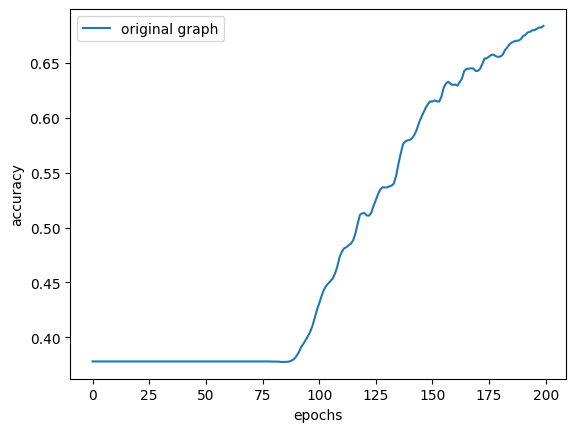

Median time per epoch: 0.12752580642700195s
Overall time: 25.997615814208984s
Best validation accuracy: 0.68


In [24]:


fg_model = GCN(num_features, 16, num_classes).to(device)
fg_criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
fg_optimizer = torch.optim.Adam(fg_model.parameters(), lr=0.01)  # Define optimizer.
fg_best_val_acc, fg_accs, fg_median_time_per_epoch, fg_overall_time = eval_model(fg_model, dataG, train_mask, test_mask, fg_optimizer,N_EPOCHS)
fig, ax = plt.subplots()

ax.plot(range(len(fg_accs)), fg_accs, label='original graph')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

print(f"Median time per epoch: {fg_median_time_per_epoch}s")
print(f"Overall time: {fg_overall_time}s")
print(f"Best validation accuracy: {fg_best_val_acc:.2f}")


## Evaluating the model on the metric backbone of the Adamic-Adar weighted graph

In [16]:
print(f"{dataG.x.shape}")

torch.Size([13752, 767])


Epoch: 001, Loss: 2.3023, Train: 0.3722, Test: 0.3780
Epoch: 010, Loss: 2.1362, Train: 0.3722, Test: 0.3780
Epoch: 020, Loss: 1.9617, Train: 0.3722, Test: 0.3780
Epoch: 030, Loss: 1.9293, Train: 0.3722, Test: 0.3780
Epoch: 040, Loss: 1.9094, Train: 0.3722, Test: 0.3780
Epoch: 050, Loss: 1.8908, Train: 0.3722, Test: 0.3780
Epoch: 060, Loss: 1.8737, Train: 0.3722, Test: 0.3780
Epoch: 070, Loss: 1.8477, Train: 0.3722, Test: 0.3780
Epoch: 080, Loss: 1.8215, Train: 0.3722, Test: 0.3780
Epoch: 090, Loss: 1.7834, Train: 0.3727, Test: 0.3774
Epoch: 100, Loss: 1.7358, Train: 0.3755, Test: 0.3797
Epoch: 110, Loss: 1.6806, Train: 0.4043, Test: 0.4047
Epoch: 120, Loss: 1.6146, Train: 0.4386, Test: 0.4405
Epoch: 130, Loss: 1.5678, Train: 0.4796, Test: 0.4812
Epoch: 140, Loss: 1.4904, Train: 0.5404, Test: 0.5454
Epoch: 150, Loss: 1.4219, Train: 0.5916, Test: 0.5955
Epoch: 160, Loss: 1.3687, Train: 0.6209, Test: 0.6233
Epoch: 170, Loss: 1.3244, Train: 0.6419, Test: 0.6427
Epoch: 180, Loss: 1.2710, Tr

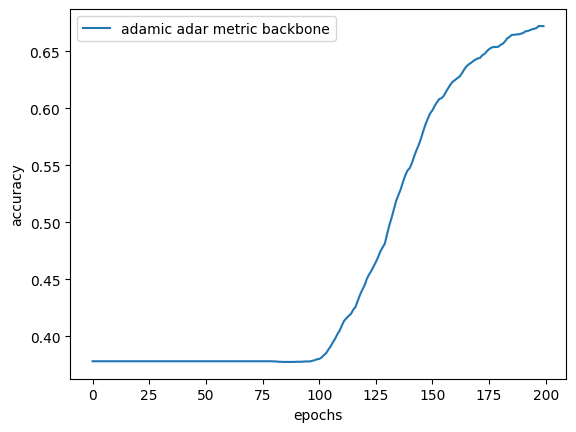

Median time per epoch: 0.12256526947021484s
Overall time: 24.577861785888672s
Best accuracy: 0.67%


In [28]:
aa_model = GCN(num_features, 16, num_classes).to(device)
aa_criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
aa_optimizer = torch.optim.Adam(aa_model.parameters(), lr=0.01)  # Define optimizer.
aa_best_val_acc, aa_accs, aa_median_time_per_epoch, aa_overall_time = eval_model(aa_model, data_AdamicAdar_mb, train_mask, test_mask, aa_optimizer, N_EPOCHS)
aa_fig, aa_ax = plt.subplots()

aa_ax.plot(range(len(aa_accs)), aa_accs, label='adamic adar metric backbone')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

print(f"Median time per epoch: {aa_median_time_per_epoch}s")
print(f"Overall time: {aa_overall_time}s")
print(f"Best accuracy: {aa_best_val_acc:.2f}%")

## Evaluating the model on the metric backbone of the Jaccard weighted graph

Epoch: 001, Loss: 2.3022, Train: 0.3999, Test: 0.4013
Epoch: 010, Loss: 2.1114, Train: 0.3722, Test: 0.3780
Epoch: 020, Loss: 1.9316, Train: 0.3722, Test: 0.3780
Epoch: 030, Loss: 1.9013, Train: 0.3722, Test: 0.3780
Epoch: 040, Loss: 1.8654, Train: 0.3722, Test: 0.3780
Epoch: 050, Loss: 1.8411, Train: 0.3722, Test: 0.3780
Epoch: 060, Loss: 1.8067, Train: 0.3722, Test: 0.3780
Epoch: 070, Loss: 1.7619, Train: 0.3726, Test: 0.3777
Epoch: 080, Loss: 1.7052, Train: 0.3736, Test: 0.3781
Epoch: 090, Loss: 1.6538, Train: 0.3866, Test: 0.3886
Epoch: 100, Loss: 1.5981, Train: 0.4330, Test: 0.4321
Epoch: 110, Loss: 1.5136, Train: 0.5143, Test: 0.5161
Epoch: 120, Loss: 1.4462, Train: 0.5705, Test: 0.5778
Epoch: 130, Loss: 1.3746, Train: 0.6158, Test: 0.6241
Epoch: 140, Loss: 1.3092, Train: 0.6478, Test: 0.6486
Epoch: 150, Loss: 1.2437, Train: 0.6582, Test: 0.6635
Epoch: 160, Loss: 1.1828, Train: 0.6726, Test: 0.6735
Epoch: 170, Loss: 1.1311, Train: 0.6806, Test: 0.6806
Epoch: 180, Loss: 1.0817, Tr

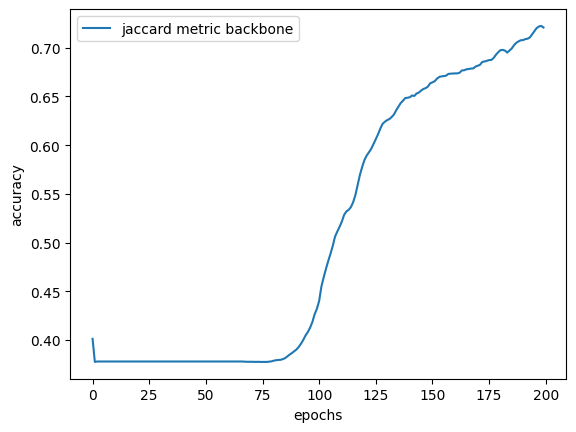

Median time per epoch: 0.03886294364929199s
Overall time: 8.022847890853882s
Best accuracy: 0.72%


In [29]:
j_model = GCN(num_features, 16, num_classes).to(device)
j_criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
j_optimizer = torch.optim.Adam(j_model.parameters(), lr=0.01)  # Define optimizer.
j_best_val_acc, j_accs, j_median_time_per_epoch, j_overall_time = eval_model(j_model, data_Jaccard_mb, train_mask, test_mask, j_optimizer, N_EPOCHS)
j_fig, j_ax = plt.subplots()

j_ax.plot(range(len(j_accs)), j_accs, label='jaccard metric backbone')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

print(f"Median time per epoch: {j_median_time_per_epoch}s")
print(f"Overall time: {j_overall_time}s")
print(f"Best accuracy: {j_best_val_acc:.2f}%")

## Evaluating the model on the threshold sparsified Jaccard Weighted graph

Epoch: 001, Loss: 2.3031, Train: 0.3915, Test: 0.3951
Epoch: 010, Loss: 2.0496, Train: 0.3722, Test: 0.3780
Epoch: 020, Loss: 1.9094, Train: 0.3722, Test: 0.3780
Epoch: 030, Loss: 1.9020, Train: 0.3722, Test: 0.3780
Epoch: 040, Loss: 1.8713, Train: 0.3722, Test: 0.3780
Epoch: 050, Loss: 1.8506, Train: 0.3722, Test: 0.3780
Epoch: 060, Loss: 1.8306, Train: 0.3722, Test: 0.3780
Epoch: 070, Loss: 1.7909, Train: 0.3726, Test: 0.3781
Epoch: 080, Loss: 1.7476, Train: 0.3748, Test: 0.3790
Epoch: 090, Loss: 1.6837, Train: 0.4010, Test: 0.4088
Epoch: 100, Loss: 1.6078, Train: 0.4226, Test: 0.4279
Epoch: 110, Loss: 1.5263, Train: 0.4693, Test: 0.4725
Epoch: 120, Loss: 1.4465, Train: 0.5567, Test: 0.5627
Epoch: 130, Loss: 1.3680, Train: 0.6321, Test: 0.6331
Epoch: 140, Loss: 1.3043, Train: 0.6579, Test: 0.6606
Epoch: 150, Loss: 1.2427, Train: 0.6736, Test: 0.6758
Epoch: 160, Loss: 1.1799, Train: 0.6902, Test: 0.6883
Epoch: 170, Loss: 1.1263, Train: 0.6975, Test: 0.6963
Epoch: 180, Loss: 1.0876, Tr

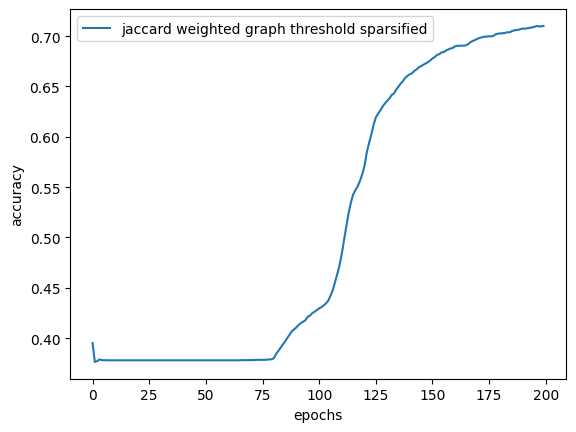

Median time per epoch: 0.03924107551574707s
Overall time: 7.968628883361816s
Best accuracy: 0.71%


In [30]:
j_thresh_model = GCN(num_features, 16, num_classes).to(device)
j_tresh_criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
j_thresh_optimizer = torch.optim.Adam(j_thresh_model.parameters(), lr=0.01)  # Define optimizer.
j_thresh_best_val_acc, j_thresh_accs, j_thresh_median_time_per_epoch, j_thresh_overall_time = eval_model(j_thresh_model, data_Jaccard_thresh, train_mask, test_mask, j_thresh_optimizer, N_EPOCHS)
j_thresh_fig, j_thresh_ax = plt.subplots()

j_thresh_ax.plot(range(len(j_thresh_accs)), j_thresh_accs, label='jaccard weighted graph threshold sparsified')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

print(f"Median time per epoch: {j_thresh_median_time_per_epoch}s")
print(f"Overall time: {j_thresh_overall_time}s")
print(f"Best accuracy: {j_thresh_best_val_acc:.2f}%")

## Evaluating the model on the random sparsified Jaccard Weighted graph

Epoch: 001, Loss: 2.3038, Train: 0.3717, Test: 0.3765
Epoch: 010, Loss: 2.1687, Train: 0.3722, Test: 0.3780
Epoch: 020, Loss: 1.9840, Train: 0.3722, Test: 0.3780
Epoch: 030, Loss: 1.9312, Train: 0.3722, Test: 0.3780
Epoch: 040, Loss: 1.9090, Train: 0.3722, Test: 0.3780
Epoch: 050, Loss: 1.8862, Train: 0.3722, Test: 0.3780
Epoch: 060, Loss: 1.8695, Train: 0.3722, Test: 0.3780
Epoch: 070, Loss: 1.8562, Train: 0.3722, Test: 0.3780
Epoch: 080, Loss: 1.8244, Train: 0.3722, Test: 0.3780
Epoch: 090, Loss: 1.7944, Train: 0.3722, Test: 0.3780
Epoch: 100, Loss: 1.7575, Train: 0.3726, Test: 0.3786
Epoch: 110, Loss: 1.7103, Train: 0.3802, Test: 0.3887
Epoch: 120, Loss: 1.6609, Train: 0.3931, Test: 0.4008
Epoch: 130, Loss: 1.6050, Train: 0.4046, Test: 0.4123
Epoch: 140, Loss: 1.5591, Train: 0.4366, Test: 0.4407
Epoch: 150, Loss: 1.4985, Train: 0.4754, Test: 0.4766
Epoch: 160, Loss: 1.4534, Train: 0.5202, Test: 0.5271
Epoch: 170, Loss: 1.4010, Train: 0.5545, Test: 0.5660
Epoch: 180, Loss: 1.3498, Tr

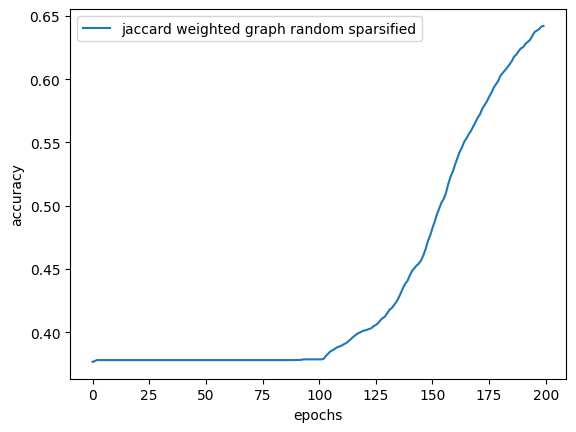

Median time per epoch: 0.060693979263305664s
Overall time: 12.218561172485352s
Best accuracy: 0.64%


In [33]:
j_rand_model = GCN(num_features, 16, num_classes).to(device)
j_rand_criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
j_rand_optimizer = torch.optim.Adam(j_rand_model.parameters(), lr=0.01)  # Define optimizer.
j_rand_best_val_acc, j_rand_accs, j_rand_median_time_per_epoch, j_rand_overall_time = eval_model(j_rand_model, data_Jaccard_rand, train_mask, test_mask, j_rand_optimizer, N_EPOCHS)
j_rand_fig, j_rand_ax = plt.subplots()

j_rand_ax.plot(range(len(j_rand_accs)), j_rand_accs, label='jaccard weighted graph random sparsified')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

print(f"Median time per epoch: {j_rand_median_time_per_epoch}s")
print(f"Overall time: {j_rand_overall_time}s")
print(f"Best accuracy: {j_rand_best_val_acc:.2f}%")

## Plots

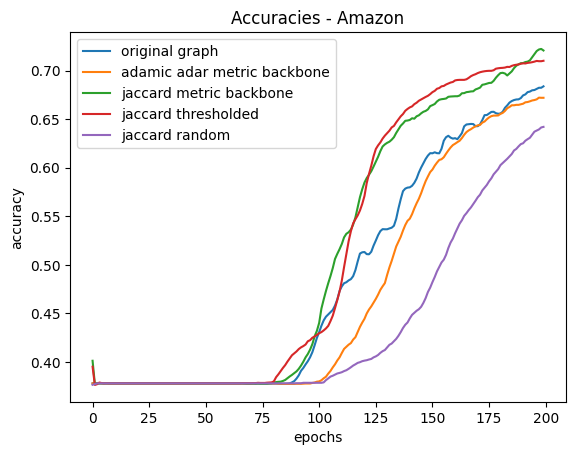

In [34]:
fig, ax = plt.subplots()
ax.plot(range(len(fg_accs)), fg_accs, label='original graph')
ax.plot(range(len(fg_accs)), aa_accs, label='adamic adar metric backbone')
ax.plot(range(len(fg_accs)), j_accs, label='jaccard metric backbone')
ax.plot(range(len(fg_accs)), j_thresh_accs, label='jaccard thresholded')
ax.plot(range(len(fg_accs)), j_rand_accs, label='jaccard random')
plt.title('Accuracies - Amazon')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()
